In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.modeling import models, fitting
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, ManualInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, gaussian
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

In [2]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"

In [3]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]


In [4]:

helium_im_collection = ImageFileCollection(red_path,
                            glob_include="HeliumrRedpoint01s_920*.fit")
helium_im_df = helium_im_collection.summary.to_pandas()

In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

(300.0, 750.0)

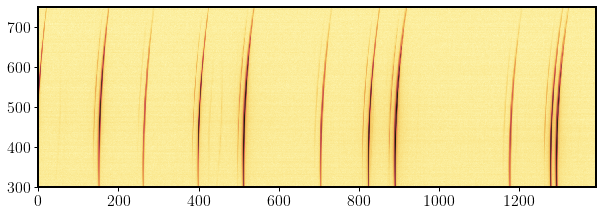

In [6]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
yaxis_slice = slice(300,750)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

(1285.0, 1300.0)

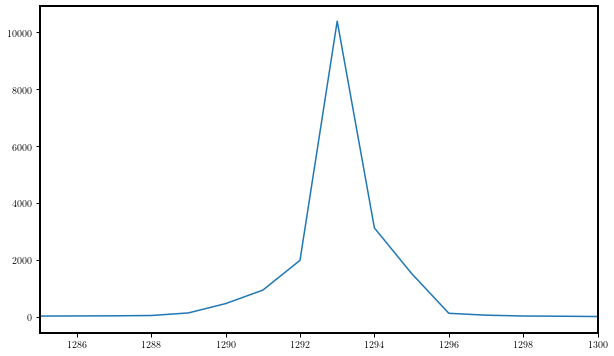

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1392), np.mean(helium_im_aver[300:305,:],axis=0))
ax.set_xlim(1285,1300)

In [8]:
helium_im_aver.shape

(1040, 1392)

In [9]:
class TraceSingleCurvature:
    def __init__(self,image, init_start, init_end, xarray = None,ybin=5):
        self.nbins = int(image.shape[0]/ybin)
        self.xpos = np.zeros(self.nbins)
        self.xpos_err = np.zeros(self.nbins)
        if xarray is None:
            self.xarray = np.arange(image.shape[1])
        
        self.wvl_region_half_length = int(np.ceil((init_end - init_start)/2))
        first_bin_slice = slice(init_start,init_end)
        first_bin = np.mean(image[:ybin,first_bin_slice],axis=0)
        
        xpos_guess = init_start + np.argmax(first_bin)
        popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[first_bin_slice],ydata=first_bin, 
                    p0=[self.xarray[xpos_guess], first_bin[xpos_guess - first_bin_slice.start]*2, 2, 0])

        self.xpos[0] = popt[0]
        self.xpos_err[0] = np.sqrt(pcov[0,0])

        for ii in range(1,self.nbins):
            ii_slice = slice(int(np.rint(self.xpos[ii - 1]) - self.wvl_region_half_length),
                            int(np.rint(self.xpos[ii - 1]) + self.wvl_region_half_length))
            ii_bin = np.mean(image[int(ii*ybin):int((ii+1)*ybin),ii_slice],axis=0)
            xpos_guess = ii_slice.start + np.argmax(ii_bin)

            popt, pcov = curve_fit(gaussian_bg,xdata=self.xarray[ii_slice],ydata=ii_bin, 
                    p0=[self.xarray[xpos_guess], ii_bin[xpos_guess - ii_slice.start]*2, 2, 0])

            self.xpos[ii] = popt[0]
            self.xpos_err[ii] = np.sqrt(pcov[0,0])

        
def gaussian_bg(wvl, line_wvl, int_total, fwhm, bg):
    return gaussian(wvl, line_wvl=line_wvl, int_total=int_total, fwhm=fwhm) + bg




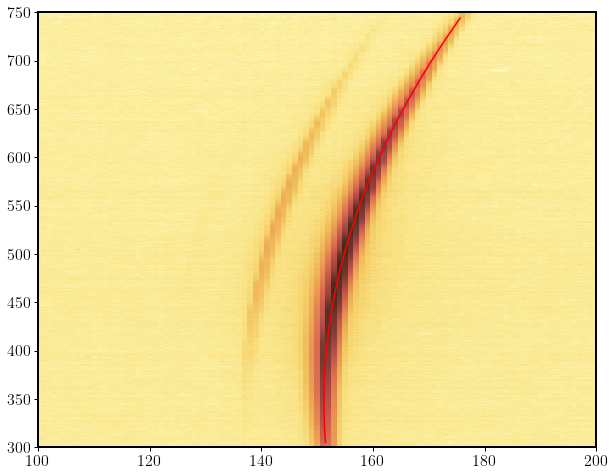

In [10]:
test_1 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=145,init_end=157)


fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_1_curve = test_1.xpos
test_1_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(100,200)

test_1_spl = UnivariateSpline(test_1_ypix, test_1_curve)
ax.plot(test_1_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [11]:
test_2 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=255,init_end=267)

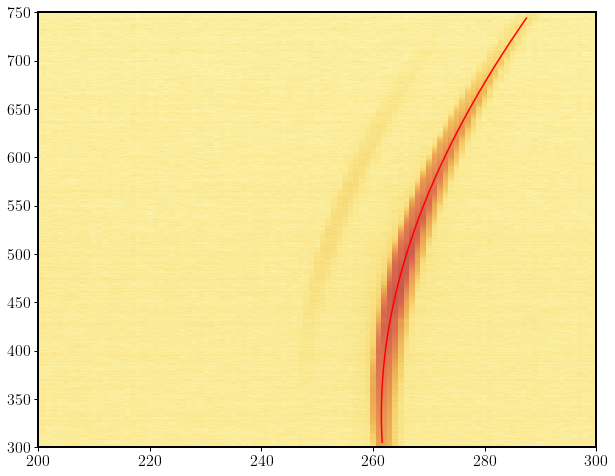

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_2_curve = test_2.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(200,300)

test_2_spl = UnivariateSpline(test_1_ypix, test_2_curve)
ax.plot(test_2_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [13]:
test_3 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=393,init_end=403)

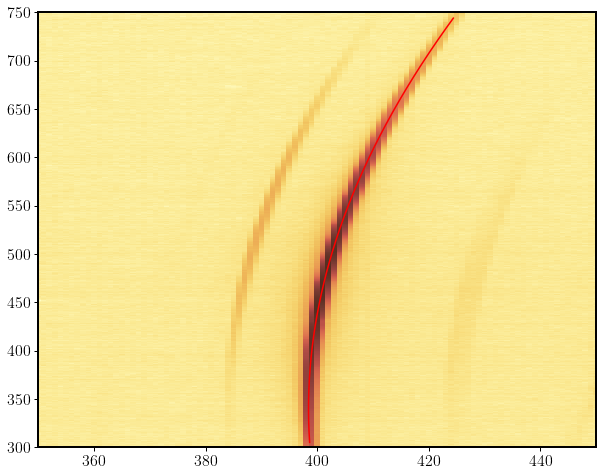

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_3_curve = test_3.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(350,450)

test_3_spl = UnivariateSpline(test_1_ypix, test_3_curve)
ax.plot(test_3_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [15]:
test_4 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=506,init_end=517)

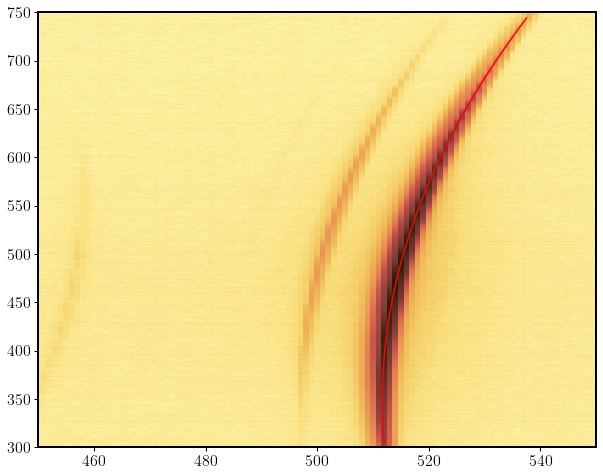

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_4_curve = test_4.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(450,550)

test_4_spl = UnivariateSpline(test_1_ypix, test_4_curve)
ax.plot(test_4_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [17]:
test_5 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=697,init_end=709)

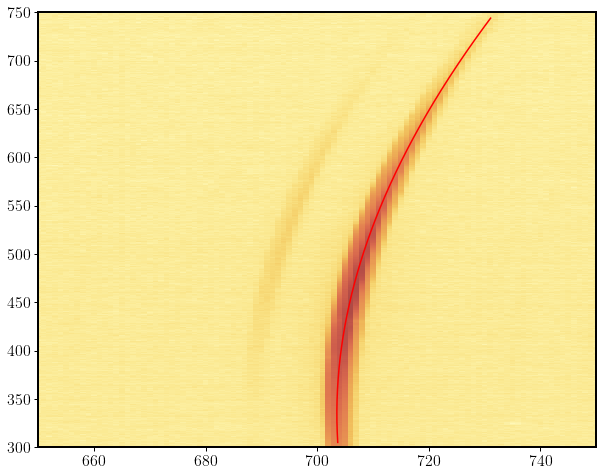

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_5_curve = test_5.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(650,750)

test_5_spl = UnivariateSpline(test_1_ypix, test_5_curve)
ax.plot(test_5_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [19]:
test_6 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=818,init_end=830)

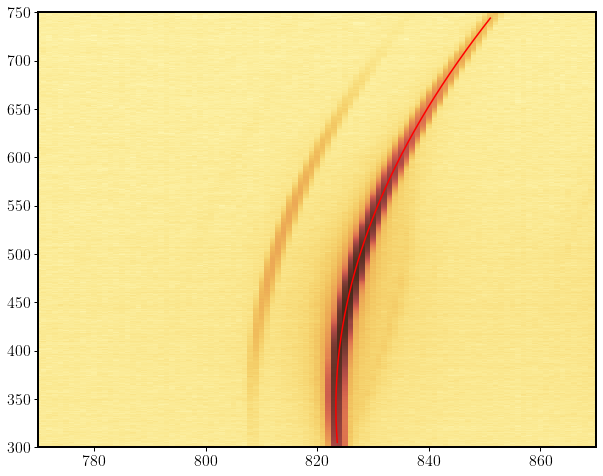

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_6_curve = test_6.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(770,870)

test_6_spl = UnivariateSpline(test_1_ypix, test_6_curve)
ax.plot(test_6_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [21]:
test_7 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=885,init_end=895)

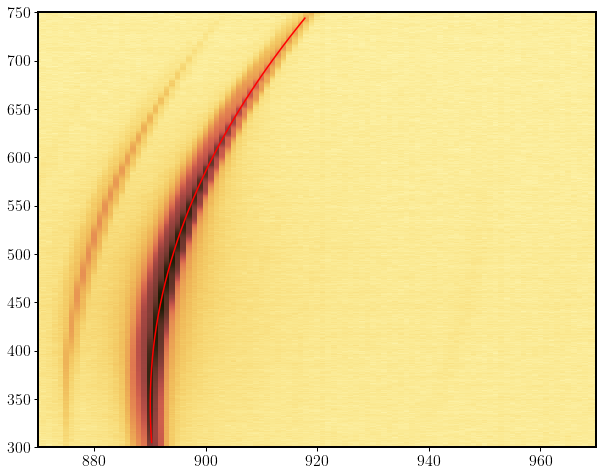

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_7_curve = test_7.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(870,970)

test_7_spl = UnivariateSpline(test_1_ypix, test_7_curve)
ax.plot(test_7_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [23]:
test_8 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1169,init_end=1184)

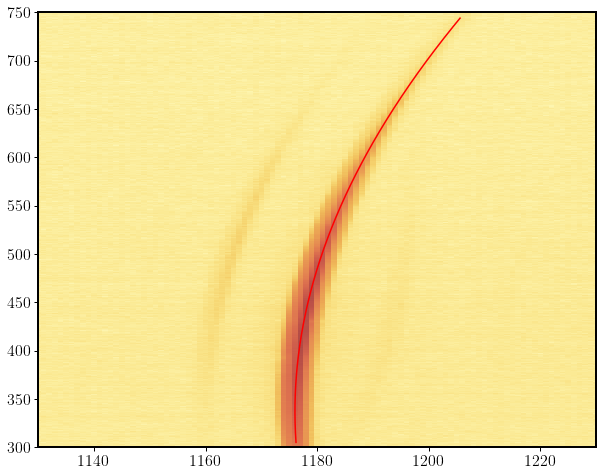

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_8_curve = test_8.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1130,1230)

test_8_spl = UnivariateSpline(test_1_ypix, test_8_curve)
ax.plot(test_8_spl(np.arange(305,745)),np.arange(305,745),color="red")

In [25]:
test_9 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1270,init_end=1284)

In [26]:
test_10 = TraceSingleCurvature(helium_im_aver[300:750,:],init_start=1285,init_end=1300)

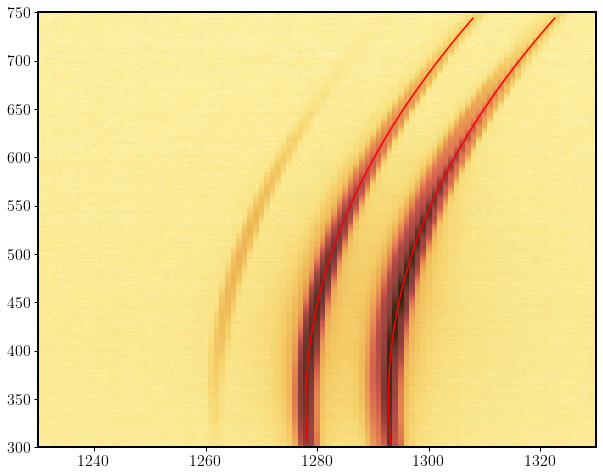

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_9_curve = test_9.xpos
test_10_curve = test_10.xpos
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1230,1330)

test_9_spl = UnivariateSpline(test_1_ypix, test_9_curve)
test_10_spl = UnivariateSpline(test_1_ypix, test_10_curve)
ax.plot(test_9_spl(np.arange(305,745)),np.arange(305,745),color="red")
ax.plot(test_10_spl(np.arange(305,745)),np.arange(305,745),color="red")

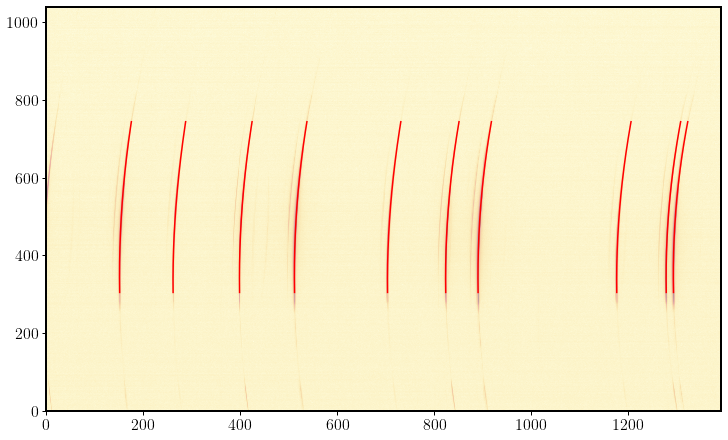

In [28]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls = (test_1_spl,test_2_spl,test_3_spl,test_4_spl,test_5_spl,
            test_6_spl,test_7_spl,test_8_spl,test_9_spl,test_10_spl)
for spl_ in spls :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")

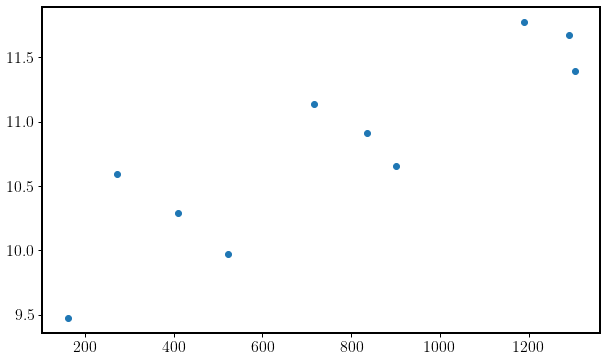

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
xpos_y600 = np.array([spl_(600) for spl_ in spls])
xpos_y400 = np.array([spl_(400) for spl_ in spls])
xshift_y600 = xpos_y600 - xpos_y400
ax.scatter(xpos_y600, xshift_y600)
ax.tick_params(labelsize=16)

In [30]:
hydrogen_im_collection = ImageFileCollection(red_path,
                            glob_include="HydrogenRedpoint1s_947*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

In [31]:
hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

(300.0, 750.0)

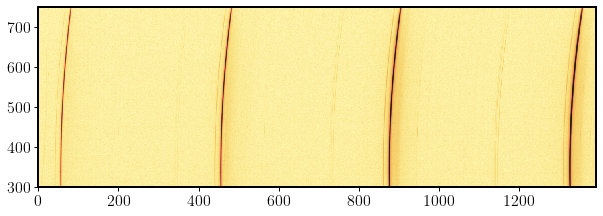

In [32]:
hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
yaxis_slice = slice(300,750)
norm_hydrogen = ImageNormalize(hydrogen_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

(1320.0, 1335.0)

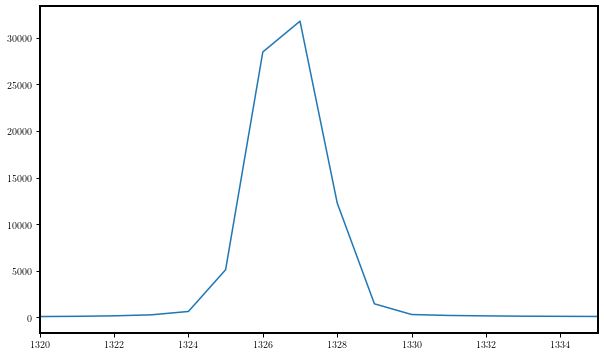

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1392), np.mean(hydrogen_im_aver[300:305,:],axis=0))
ax.set_xlim(1320,1335)

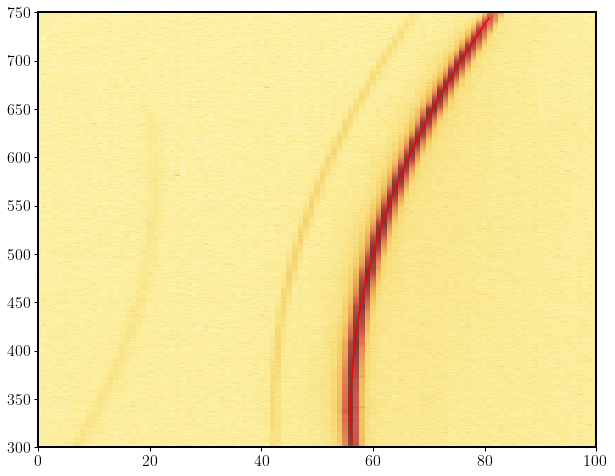

In [34]:
test_halpha1 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=50,init_end=64)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha1_curve = test_halpha1.xpos
test_halpha1_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(0,100)

test_halpha1_spl = UnivariateSpline(test_halpha1_ypix, test_halpha1_curve)
ax.plot(test_halpha1_spl(np.arange(305,745)),np.arange(305,745),color="red")

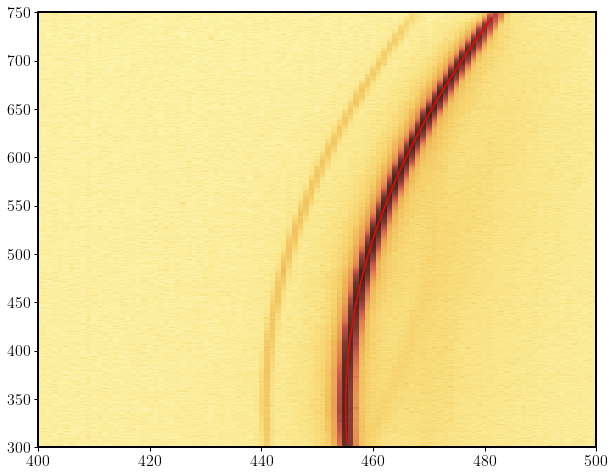

In [35]:
test_halpha2 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=448,init_end=462)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha2_curve = test_halpha2.xpos
test_halpha2_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(400,500)

test_halpha2_spl = UnivariateSpline(test_halpha2_ypix, test_halpha2_curve)
ax.plot(test_halpha2_spl(np.arange(305,745)),np.arange(305,745),color="red")

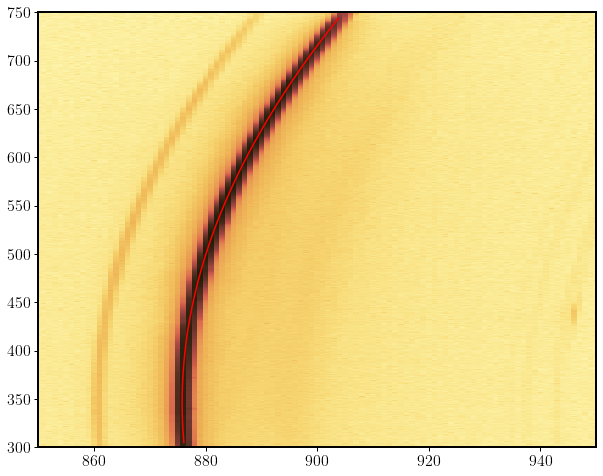

In [36]:
test_halpha3 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=870,init_end=884)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha3_curve = test_halpha3.xpos
test_halpha3_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(850,950)

test_halpha3_spl = UnivariateSpline(test_halpha3_ypix, test_halpha3_curve)
ax.plot(test_halpha3_spl(np.arange(305,745)),np.arange(305,745),color="red")

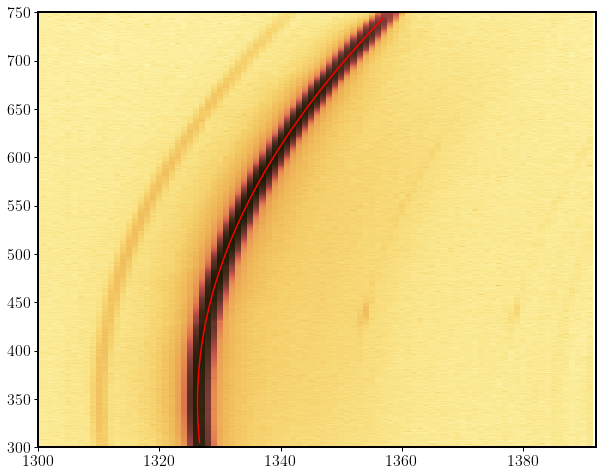

In [37]:
test_halpha4 = TraceSingleCurvature(hydrogen_im_aver[300:750,:],init_start=1320,init_end=1335)

fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True)
ax.tick_params(labelsize=16)
ax.set_ylim(yaxis_slice.start, yaxis_slice.stop)

test_halpha4_curve = test_halpha4.xpos
test_halpha4_ypix = np.arange(302,750,5)
#ax.step(test_1_curve, test_1_ypix, color="white",alpha=0.7)
ax.set_xlim(1300,1392)

test_halpha4_spl = UnivariateSpline(test_halpha4_ypix, test_halpha4_curve)
ax.plot(test_halpha4_spl(np.arange(305,745)),np.arange(305,745),color="red")

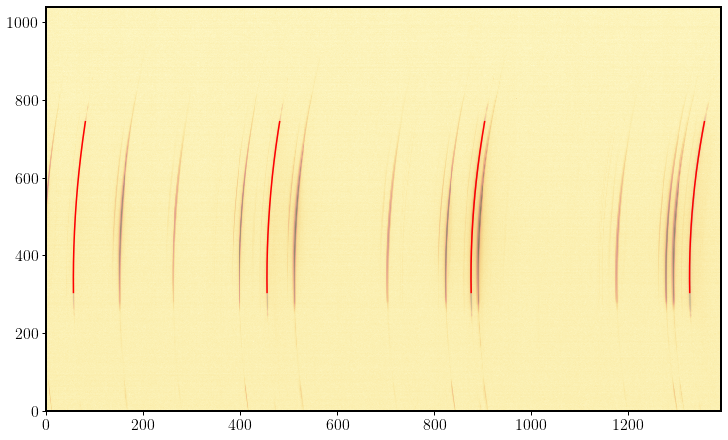

In [38]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls_halpha = (test_halpha1_spl,test_halpha2_spl,test_halpha3_spl,test_halpha4_spl)
for spl_ in spls_halpha :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")

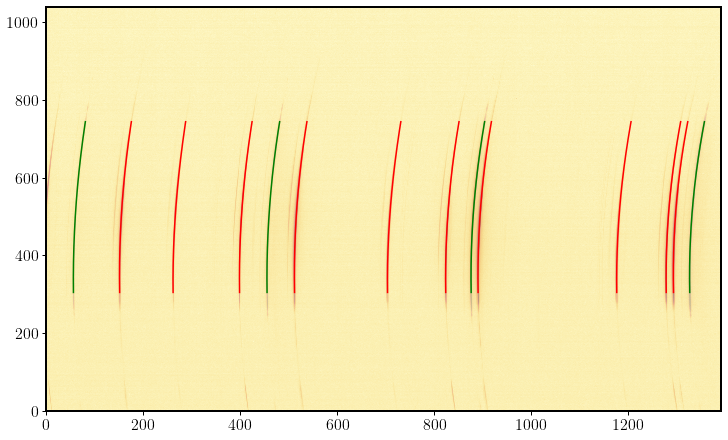

In [39]:
fig, ax = plt.subplots(figsize=(10,6),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm_hydrogen,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,alpha=0.5)
ax.tick_params(labelsize=16)

spls_halpha = (test_halpha1_spl,test_halpha2_spl,test_halpha3_spl,test_halpha4_spl)
for spl_ in spls :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="red")
for spl_ in spls_halpha :
    ax.plot(spl_(np.arange(305,745)),np.arange(305,745),color="green")

In [40]:
spls_all = (test_halpha1_spl, test_1_spl, test_2_spl, test_3_spl,
            test_halpha2_spl, test_4_spl, test_5_spl, test_6_spl,
            test_halpha3_spl, test_7_spl, test_8_spl, test_9_spl,
            test_10_spl, test_halpha4_spl)
ypos_tofit = np.tile(np.arange(305,745),(14,1)).T
xpos_tofit = np.zeros_like(ypos_tofit)
for ii, spl_ in enumerate(spls_all):
    xpos_tofit[:,ii] = spl_(ypos_tofit[:,ii])
xshift_tofit = xpos_tofit - xpos_tofit[95,:]

In [41]:
chebyshev2d_init = models.Chebyshev2D(x_degree=6,y_degree=6)
fit_chebyshev2d = fitting.LevMarLSQFitter()
chebyshev2d_p = fit_chebyshev2d(chebyshev2d_init,xpos_tofit, ypos_tofit, xshift_tofit)

Text(0, 0.5, '')

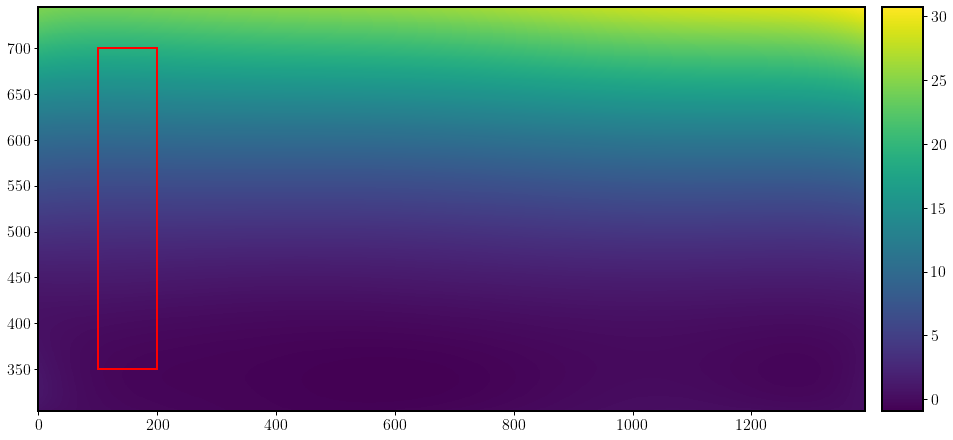

In [42]:
ypos_plot, xpos_plot = np.mgrid[305:745,:1392]
fig, ax = plt.subplots(figsize=(12,6),constrained_layout=True)
im = ax.pcolormesh(xpos_plot, ypos_plot, chebyshev2d_p(xpos_plot, ypos_plot),rasterized=True)

testx_slice = slice(100,200)
testy_slice = slice(350,700)

test_rectangle = Rectangle((testx_slice.start, testy_slice.start), 
                    testx_slice.stop - testx_slice.start,
                    testy_slice.stop - testy_slice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(test_rectangle)

ax.tick_params(labelsize=16)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [43]:
# class ChebyShevMappinig:
#     def __init__(self,chebyshev_model):
#         self.chebyshev_model = chebyshev_model

#     def shift_func(self, output_coords):
#         return (output_coords[0] - self.chebyshev_model(output_coords[0],output_coords[1]), output_coords[1])

In [44]:
# def shift_func(output_coords):
#     return (output_coords[0], 
#             output_coords[1] + chebyshev2d_p(output_coords[1]+100,output_coords[0]+350))

In [45]:
# helium_trans_test = ndimage.geometric_transform(helium_im_aver[testy_slice, testx_slice],shift_func)

In [46]:
# fig, ax = plt.subplots(figsize=(4,8),constrained_layout=True)
# ax.pcolormesh(np.arange(testx_slice.start,testx_slice.stop),np.arange(testy_slice.start,testy_slice.stop),
#             helium_trans_test,norm=norm,cmap=cmcm.lajolla,rasterized=True)

In [47]:
testx_slice_mapcoor = slice(100,1350)
testy_slice_mapcoor = slice(350,700)
ypos_map_coordinate, xpos_map_coordinate = np.mgrid[testy_slice_mapcoor,testx_slice_mapcoor]
xpos_map_coordinate = xpos_map_coordinate + chebyshev2d_p(xpos_map_coordinate, ypos_map_coordinate)

xpos_map_coordinate = xpos_map_coordinate - testx_slice_mapcoor.start
ypos_map_coordinate = ypos_map_coordinate - testy_slice_mapcoor.start


In [48]:
helium_trans_mapcoor = ndimage.map_coordinates(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate))

Text(0, 0.5, '')

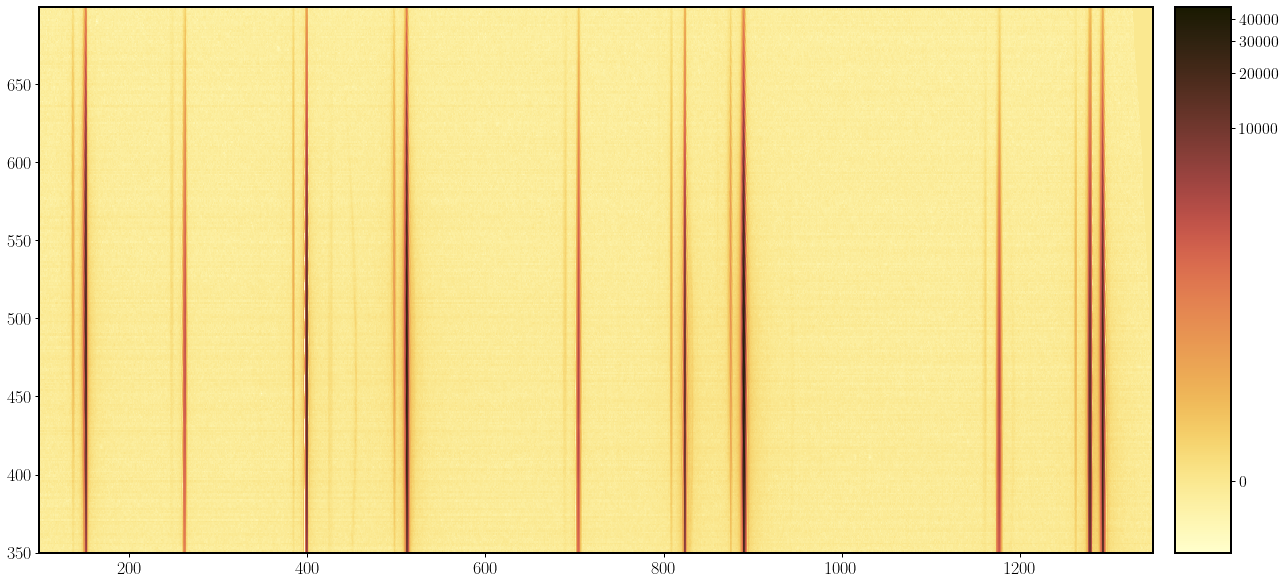

In [49]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)

clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [50]:
mylar_im_collection = ImageFileCollection(red_path,
                            glob_include="SunMylarRedpoint1s_740*.fit")
mylar_im_df = mylar_im_collection.summary.to_pandas()

In [51]:
mylar_image_cube = np.zeros((1040,1392,10))

for ii, row_ in mylar_im_df.iterrows():
    mylar_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

mylar_im_aver = np.mean(mylar_image_cube,axis=2)

In [52]:
mylar_trans_mapcoor = ndimage.map_coordinates(mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate))

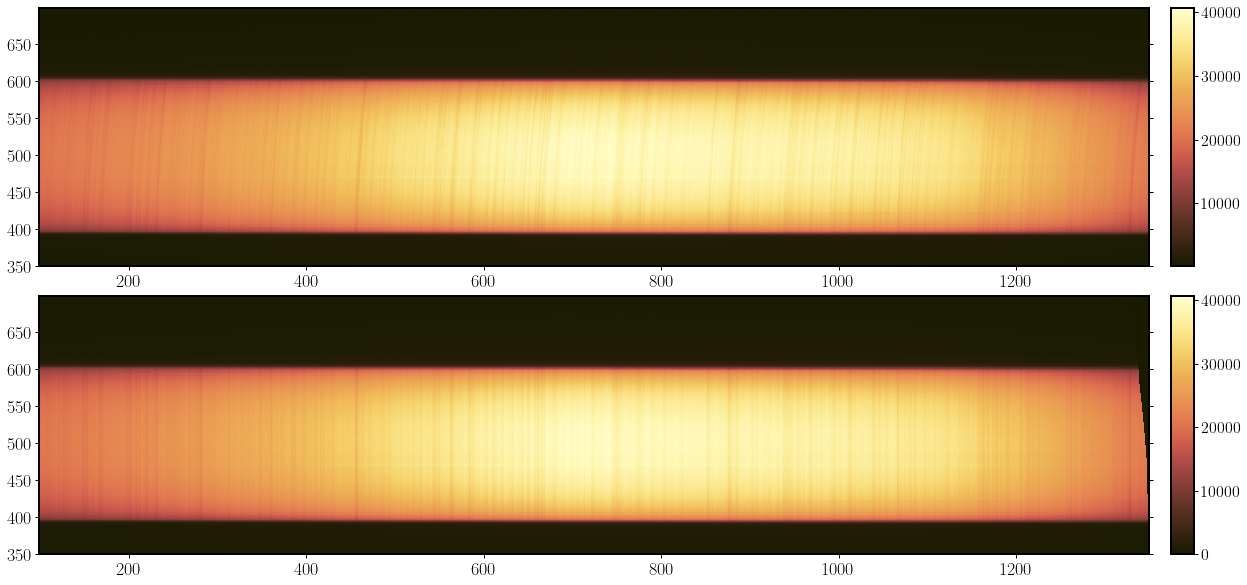

In [53]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,pad = 0.05,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

Text(0, 0.5, '')

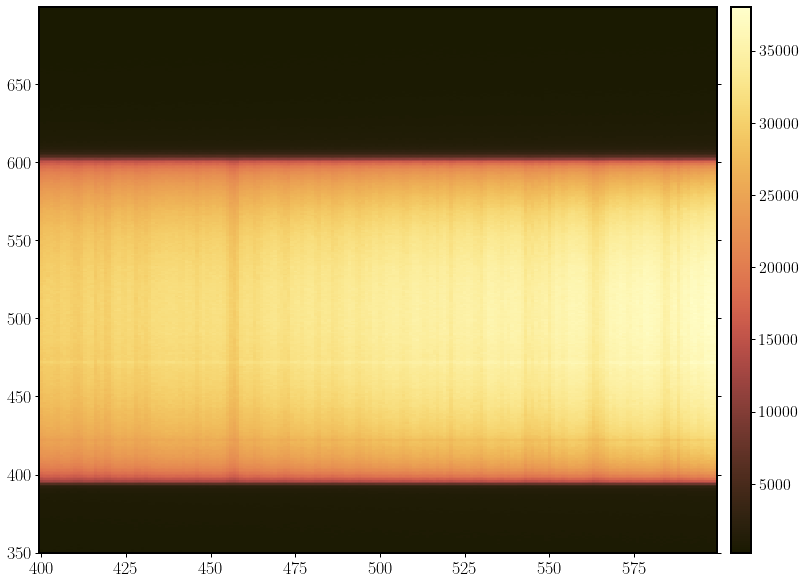

In [54]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(400,600),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            mylar_trans_mapcoor[:,300:500],cmap=cmcm.lajolla_r,rasterized=True)
ax.tick_params(labelsize=18,right=True)
clb_ax = inset_axes(ax,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

In [55]:
fname_skyflat_red_1s = ["SkyRed1s_6141.fit","SkyRed1s_6142.fit","SkyRed1s_6143.fit","SkyRed1s_6144.fit",
                        "SkyRed1s_6145.fit","SkyRed1s_6146.fit","SkyRed1s_6147.fit","SkyRed1s_6148.fit",
                        "SkyRed1s_6149.fit","SkyRed1s_6150.fit","SkyRed1s_6151.fit","SkyRed1s_6152.fit",
                        "SkyRed1s_6153.fit","SkyRed1s_6154.fit","SkyRed1s_6155.fit"]

skyflat_im_collection = ImageFileCollection(red_path,
                            filenames=fname_skyflat_red_1s)
skyflat_im_df = skyflat_im_collection.summary.to_pandas()
skyflat_im_df

file  simple  bitpix  naxis  naxis1  naxis2    bzero  bscale  \
0   SkyRed1s_6141.fit    True      16      2    1392    1040  32768.0     1.0   
1   SkyRed1s_6142.fit    True      16      2    1392    1040  32768.0     1.0   
2   SkyRed1s_6143.fit    True      16      2    1392    1040  32768.0     1.0   
3   SkyRed1s_6144.fit    True      16      2    1392    1040  32768.0     1.0   
4   SkyRed1s_6145.fit    True      16      2    1392    1040  32768.0     1.0   
5   SkyRed1s_6146.fit    True      16      2    1392    1040  32768.0     1.0   
6   SkyRed1s_6147.fit    True      16      2    1392    1040  32768.0     1.0   
7   SkyRed1s_6148.fit    True      16      2    1392    1040  32768.0     1.0   
8   SkyRed1s_6149.fit    True      16      2    1392    1040  32768.0     1.0   
9   SkyRed1s_6150.fit    True      16      2    1392    1040  32768.0     1.0   
10  SkyRed1s_6151.fit    True      16      2    1392    1040  32768.0     1.0   
11  SkyRed1s_6152.fit    True      16      2    1392    1040  32768.0     1.0   
12  SkyRed1s_6153.fit    True      16      2    1392    1040  32768.0     1.0   
13  SkyRed1s_6154.fit    True      16      2    1392    1040  32768.0     1.0   
14  SkyRed1s_6155.fit    True      16      2    1392    1040  32768.0     1.0   

    datamin  datamax  ... ypixsz  xbinning ybinning  xorgsubf  yorgsubf  \
0       0.0  65535.0  ...   6.45         1        1         0         0   
1       0.0  65535.0  ...   6.45         1        1         0         0   
2       0.0  65535.0  ...   6.45         1        1         0         0   
3       0.0  65535.0  ...   6.45         1        1         0         0   
4       0.0  65535.0  ...   6.45         1        1         0         0   
5       0.0  65535.0  ...   6.45         1        1         0         0   
6       0.0  65535.0  ...   6.45         1        1         0         0   
7       0.0  65535.0  ...   6.45         1        1         0         0   
8       0.0  65535.0  ...   6.45         1        1         0         0   
9       0.0  65535.0  ...   6.45         1        1         0         0   
10      0.0  65535.0  ...   6.45         1        1         0         0   
11      0.0  65535.0  ...   6.45         1        1         0         0   
12      0.0  65535.0  ...   6.45         1        1         0         0   
13      0.0  65535.0  ...   6.45         1        1         0         0   
14      0.0  65535.0  ...   6.45         1        1         0         0   

    xpossubf  ypossubf  cblack  cwhite         swcreate  
0          0         0     824    4753  Artemis Capture  
1          0         0     819    4756  Artemis Capture  
2          0         0     817    4760  Artemis Capture  
3          0         0     819    4756  Artemis Capture  
4          0         0     817    4753  Artemis Capture  
5          0         0     817    4750  Artemis Capture  
6          0         0     822    4754  Artemis Capture  
7          0         0     823    4757  Artemis Capture  
8          0         0     820    4757  Artemis Capture  
9          0         0     818    4749  Artemis Capture  
10         0         0     816    4745  Artemis Capture  
11         0         0     813    4752  Artemis Capture  
12         0         0     819    4748  Artemis Capture  
13         0         0     820    4751  Artemis Capture  
14         0         0     818    4751  Artemis Capture  

[15 rows x 24 columns]

In [56]:
skyflat_image_cube = np.zeros((1040,1392,15))

for ii, row_ in skyflat_im_df.iterrows():
    skyflat_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

skyflat_im_aver = np.mean(skyflat_image_cube,axis=2)

In [57]:
skyflat_trans_mapcoor = ndimage.map_coordinates(skyflat_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate))

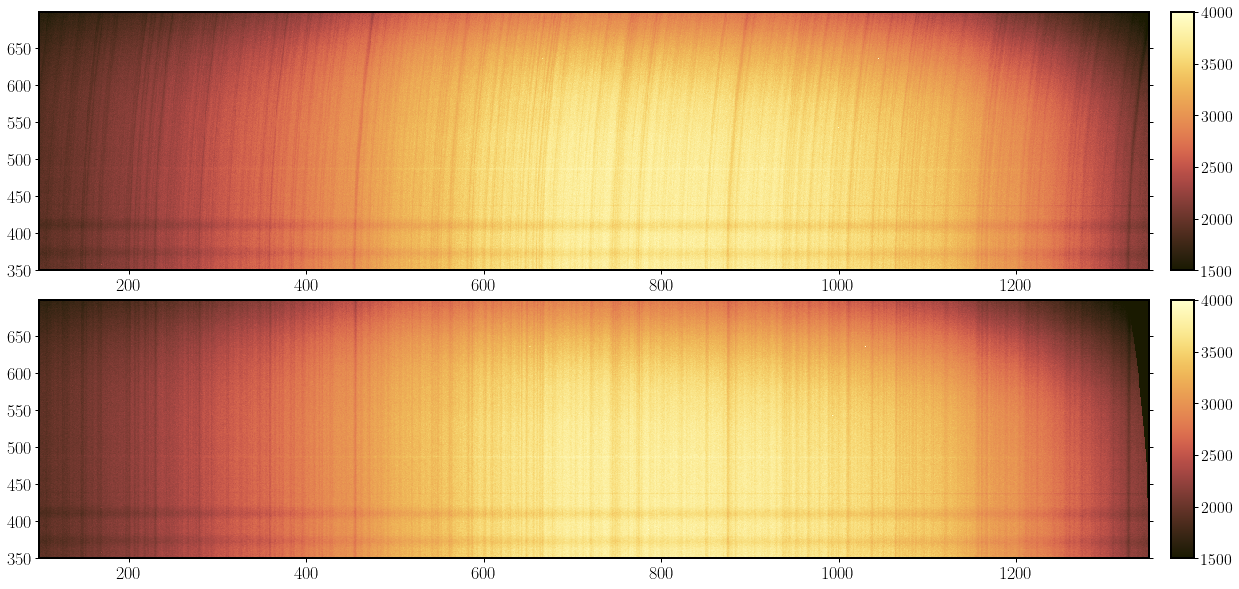

In [58]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            skyflat_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla_r,rasterized=True,vmin=1500,vmax=4000)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            skyflat_trans_mapcoor,cmap=cmcm.lajolla_r,rasterized=True,vmin=1500,vmax=4000)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,pad = 0.05,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

In [59]:
totality_image = CCDData.read(os.path.join(red_path,"TotalitySequenceRed_7723.fit"),unit="adu").data - bias_dc_red_1s

In [60]:
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate))

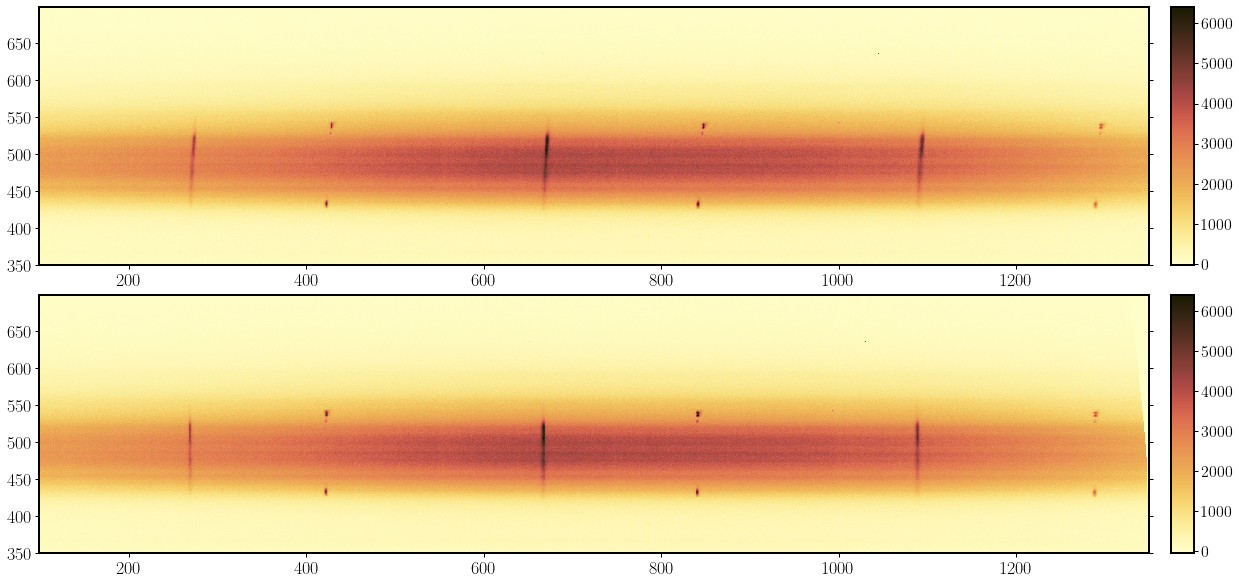

In [61]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout=True)
im1 = ax1.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_image[testy_slice_mapcoor, testx_slice_mapcoor],cmap=cmcm.lajolla,rasterized=True)
im2 = ax2.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,cmap=cmcm.lajolla,rasterized=True)

for ax_, im_ in zip((ax1,ax2),(im1, im2)):
    ax_.tick_params(labelsize=18,right=True)
    clb_ax = inset_axes(ax_,width="2%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im_,pad = 0.05,orientation='vertical',ax=ax_,cax=clb_ax)
    clb_ax.tick_params(labelsize=16)
    clb_ax.yaxis.get_offset_text().set_fontsize(16)
    clb_ax.set_ylabel('',fontsize=16)

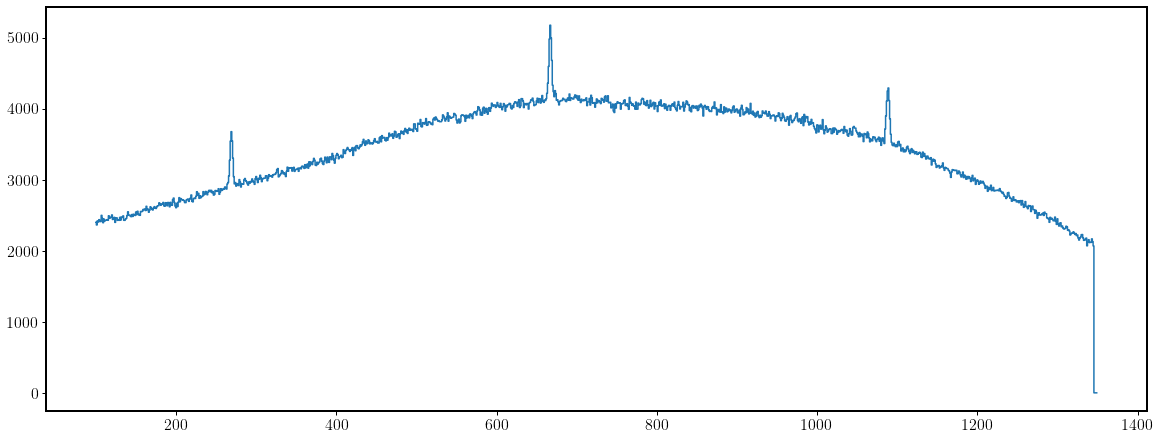

In [62]:
totality_spectrum_1d = np.mean(totality_trans_mapcoor[130:140,:],axis=0)
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
ax.step(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),totality_spectrum_1d,where="mid")
ax.tick_params(labelsize=16)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

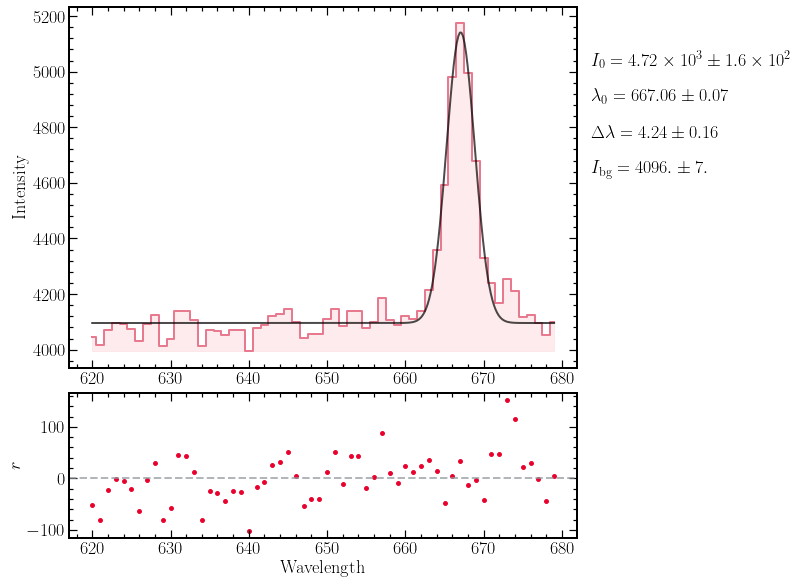

In [63]:
totality_spectrum_1d_zoomin_slice = slice(520,580)
totality_spectrum_1d_zoomin = totality_spectrum_1d[totality_spectrum_1d_zoomin_slice]
totality_spectrum_1d_x = np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop)[totality_spectrum_1d_zoomin_slice]

totality_spectrum_corr_fit = SpectrumFitSingle(data=totality_spectrum_1d_zoomin,wvl=totality_spectrum_1d_x,line_number=1,
                                            line_wvl_init=665,int_max_init=1200,fwhm_init=5,same_width=False,
                                        )
totality_spectrum_corr_fit.run_lse()                                    
totality_spectrum_corr_fit.plot(plot_fit=True)